In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finance_byu.summarize import summary
import statsmodels.formula.api as smf
import yfinance as yf
import seaborn as sns

In [323]:
# GOAL: Determine if there is a statistically significant relationship between our formation variables beme + sg
# and our holding period return

In [324]:
df = pd.read_parquet("~/Data/BOQ_data.parquet")

df.tail()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,s2invt,s2rect,sale,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv
3568650,0.211263,0.114912,-0.746238,0.861151,-12.189408,2023-08-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000152,0.708916,2.250092e+07,-1.580970
3568651,0.211263,0.114912,-0.750723,0.865635,-11.613183,2023-09-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000133,0.465122,1.476294e+07,-0.371920
3568652,0.211263,0.114912,-0.731231,0.846143,-12.752123,2023-10-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000177,0.531342,1.686876e+07,0.809301
3568653,0.211263,0.114912,-0.731231,0.846143,-7.943286,2023-11-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000245,0.614813,1.954419e+07,0.278301
3568654,0.211263,0.114912,-0.731231,0.846143,-9.359996,2023-12-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000186,0.599491,1.905735e+07,0.967711


In [325]:
# Create initial dataframe. Keep only necessary columns, and generate date variables

keep = ['DATE', 'PERMNO', 'BEME', 'E2P', 'sale', 'ME', 'PRC', 'RET', ]

df = df[keep]

df = df.rename(columns={'DATE':'caldt','PERMNO':'permno','BEME':'beme', 'E2P': 'ep', 'sale': 'sales', 'ME': 'me', 'PRC':'prc', 'RET': 'ret'})

df = df.sort_values(['permno','caldt'])

df['mdt'] = df['caldt'].dt.strftime("%Y-%m")
df['month'] = df['caldt'].dt.strftime("%m")
df['year'] = df['caldt'].dt.strftime("%Y")

# In sample period
start = '1963-04-01'
end = '1990-04-30'

# Out of sample period
# start = '1990-04-30'
# end = '2024-10-07'

df = df[df['caldt'] >= start]
df = df[df['caldt'] <= end]

df = df.reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08,1985
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09,1985
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10,1985
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11,1985
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12,1985


In [326]:
# Generate features from the last 12 months

formation_period = 60 # months ~ 5 years (same as paper)

# 1 month sales growth
df['sg'] = df.groupby("permno")['sales'].pct_change(fill_method=None)

# Log 1 months sales growth
df['log_sg'] = np.log(1+df['sg'])

# Past 5 year log sales growth
df[f'log_sg_{formation_period}'] = df.groupby('permno').rolling(formation_period,formation_period)['log_sg'].sum().reset_index(drop=True)

df.tail()

/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_60
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08,1985,NaN,NaN,NaN
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09,1985,NaN,NaN,NaN
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10,1985,NaN,NaN,NaN
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11,1985,NaN,NaN,NaN
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12,1985,NaN,NaN,NaN


In [327]:
# Generate target variable

# Log 1 month return
df['log_ret'] = np.log(1 + df['ret'])

holding_period = 12 # months
holding_period_ret = f'ret_{holding_period}'

# 12 month holding period return
df[holding_period_ret] = df.groupby('permno').rolling(holding_period,holding_period)['log_ret'].sum().reset_index(drop=True)
df[holding_period_ret] = df.groupby('permno')[holding_period_ret].shift(-(holding_period-1))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_60,log_ret,ret_12
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08,1985,NaN,NaN,NaN,-0.154151,NaN
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09,1985,NaN,NaN,NaN,-0.182322,NaN
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10,1985,NaN,NaN,NaN,0.336472,NaN
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11,1985,NaN,NaN,NaN,-0.154151,NaN
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12,1985,NaN,NaN,NaN,-0.154151,NaN


In [328]:
# Lag all formation variables by 1 month
df['beme_lag'] = df.groupby('permno')['beme'].shift(1)
df['sg_lag'] = df.groupby('permno')[f'log_sg_{formation_period}'].shift(1)
df['prc_lag'] = df.groupby('permno')['prc'].shift(1)

# Remove stocks that don't have formation variables and low priced stocks
df = df.query("beme_lag == beme_lag and sg_lag == sg_lag and prc_lag >= 5").reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_60,log_ret,ret_12,beme_lag,sg_lag,prc_lag
471814,1987-05-31,92946.0,1.165149,0.137030,87.477,22612.875,5.875,-0.040816,1987-05,05,1987,0.000000,0.000000,3.599664,-0.041673,-1.119232,1.165149,3.599664,6.125
471815,1987-06-30,92946.0,1.165149,0.137030,87.477,20233.125,5.625,-0.042553,1987-06,06,1987,0.000000,0.000000,3.599664,-0.043485,-1.211090,1.165149,3.599664,5.875
471816,1987-07-31,92946.0,1.320248,0.011195,101.474,20233.125,5.625,0.000000,1987-07,07,1987,0.160008,0.148427,4.186074,0.000000,-1.098612,1.165149,3.599664,5.625
471817,1987-08-31,92946.0,1.320248,0.011195,101.474,18434.625,5.125,-0.088889,1987-08,08,1987,0.000000,0.000000,4.186074,-0.093090,-1.098612,1.320248,4.186074,5.625
471818,1987-09-30,92946.0,1.320248,0.011195,101.474,14755.125,4.125,-0.195122,1987-09,09,1987,0.000000,0.000000,4.186074,-0.217064,-1.271225,1.320248,4.186074,5.125


In [329]:
# Filter dataframe to just the months of august (this is the month that we have data to trade on)

df = df.query(f"month == '08' and {holding_period_ret} == {holding_period_ret}")

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_60,log_ret,ret_12,beme_lag,sg_lag,prc_lag
471770,1983-08-31,92946.0,1.469862,0.019542,2.300,26154.375,13.8750,-0.082645,1983-08,08,1983,0.0,0.0,-0.021932,-0.086260,-0.413764,1.469862,-0.021932,15.125
471781,1984-08-31,92946.0,0.353732,0.039532,29.877,23267.875,6.0625,0.212500,1984-08,08,1984,0.0,0.0,2.594191,0.192684,0.300105,0.353732,2.594191,5.000
471793,1985-08-31,92946.0,1.127671,0.136579,57.965,24947.000,6.5000,-0.037037,1985-08,08,1985,0.0,0.0,3.114767,-0.037740,0.054067,1.127671,3.114767,6.750
471805,1986-08-31,92946.0,1.165149,0.137030,87.477,26386.250,6.8750,-0.035088,1986-08,08,1986,0.0,0.0,3.599664,-0.035718,-0.236389,1.165149,3.599664,7.125
471817,1987-08-31,92946.0,1.320248,0.011195,101.474,18434.625,5.1250,-0.088889,1987-08,08,1987,0.0,0.0,4.186074,-0.093090,-1.098612,1.320248,4.186074,5.625


In [330]:
# Find the correlation of our formation variables on our holding period return

corr1 = np.corrcoef(df[holding_period_ret], df['sg_lag'])[0,1]
corr2 = np.corrcoef(df[holding_period_ret], df['beme_lag'])[0,1]

print(f"Correlation with sg_lag: {round(corr1,3)}")
print(f"Correlation with beme_lag: {round(corr2,3)}")

Correlation with sg_lag: -0.017
Correlation with beme_lag: 0.136


In [331]:
# Group data frame by year and stock. Basically just creating a cross-section each year

years = df.groupby(['year', 'permno']).agg({'caldt': 'last', 'beme_lag': 'last', 'sg_lag': 'last', holding_period_ret: 'last'}).reset_index()

min_year = int(min(years['year']))
max_year = int(max(years['year'])) + 1

print(f"Running regressions from {min_year} to {max_year}")

Running regressions from 1968 to 1989


In [332]:
# Gather regression results for each year and create a summary dataframe

summary_data = []

years = df.groupby(['year', 'permno']).agg({'caldt': 'last', 'beme_lag': 'last', 'sg_lag': 'last', holding_period_ret: 'last'}).reset_index()

for year in range(min_year,max_year):
    cur_df = years[years['year'] == str(year)]
    
    model = smf.ols(f"{holding_period_ret} ~ beme_lag + sg_lag", data=cur_df).fit()
    
    summary_data.append({
        'year': year,
        'r_squared': model.rsquared,
        'coef_beme_lag': model.params.get('beme_lag', float('nan')),
        'coef_sg_lag': model.params.get('sg_lag', float('nan')),
        't_stat_beme_lag': model.tvalues.get('beme_lag', float('nan')),
        't_stat_sg_lag': model.tvalues.get('sg_lag', float('nan'))
    })

summary_df = pd.DataFrame(summary_data)

summary_df

,year,r_squared,coef_beme_lag,coef_sg_lag,t_stat_beme_lag,t_stat_sg_lag
0,1968,0.010812,0.036027,-0.040715,1.641727,-2.143771
1,1969,0.036190,0.079192,-0.096257,2.219719,-4.750954
2,1970,0.005511,-0.015371,0.028872,-0.967016,1.898823
3,1971,0.002544,0.013641,-0.020720,0.975189,-1.268894
4,1972,0.027600,0.042677,-0.085303,2.634794,-4.647742
5,1973,0.136733,0.177692,-0.123269,10.478624,-6.402298
6,1974,0.000064,0.001513,-0.003656,0.154382,-0.188380
7,1975,0.063322,0.033409,-0.078089,6.868527,-5.191285
8,1976,0.043477,0.058618,0.007335,7.627434,0.425131
9,1977,0.006450,0.020491,-0.025895,2.348633,-1.430860


In [333]:
# Describe the summary statistics for the summary table

round(summary_df.describe(),3)

,year,r_squared,coef_beme_lag,coef_sg_lag,t_stat_beme_lag,t_stat_sg_lag
count,21.000,21.000,21.000,21.000,21.000,21.000
mean,1978.000,0.025,0.036,-0.025,2.887,-1.519
std,6.205,0.033,0.053,0.046,4.278,2.914
min,1968.000,0.000,-0.069,-0.123,-7.215,-6.402
25%,1973.000,0.004,0.013,-0.043,0.860,-2.908
50%,1978.000,0.011,0.026,-0.025,2.118,-1.991
75%,1983.000,0.042,0.059,-0.004,4.855,-0.188
max,1988.000,0.137,0.178,0.067,10.549,4.714


In [334]:
# Example regression for a single year

year1 = years[years['year'] == str(min_year)] # 1968 - 1988

model = smf.ols(f"ret_{holding_period} ~ beme_lag + sg_lag", data=year1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_12   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.023
Date:                Wed, 09 Oct 2024   Prob (F-statistic):            0.00677
Time:                        11:18:19   Log-Likelihood:                -87.087
No. Observations:                 922   AIC:                             180.2
Df Residuals:                     919   BIC:                             194.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1212      0.021     -5.799      0.000      -0.162      -0.080
beme_lag       0.0360      0.022      1.642      0.101      -0.007       0.079
sg_lag        -0.0407      0.019     -2.144      0.032      -0.078      -0.003
==============================================================================
Omnibus:                       31.788   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.268
Skew:                          -0.104   Prob(JB):                     2.75e-17
Kurtosis:                       4.394   Cond. No.                         4.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

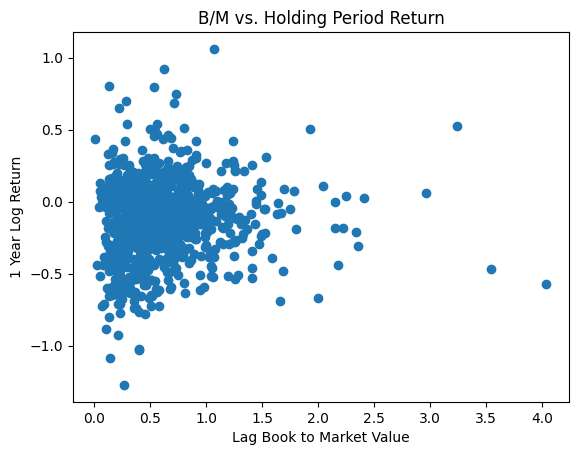

In [335]:
plt.scatter(year1['beme_lag'], year1[holding_period_ret])
plt.title("B/M vs. Holding Period Return")
plt.xlabel("Lag Book to Market Value")
plt.ylabel("1 Year Log Return")
plt.show()

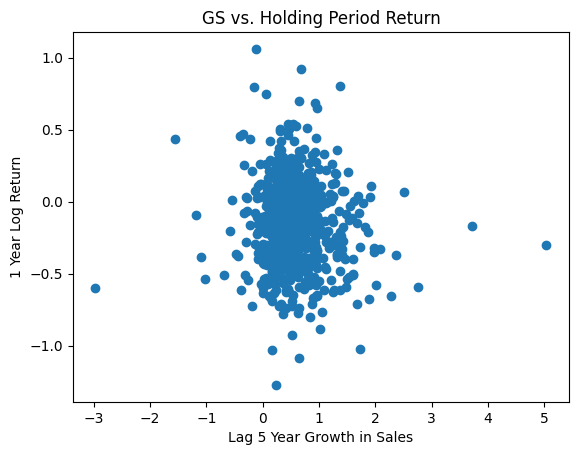

In [336]:
plt.scatter(year1['sg_lag'], year1[holding_period_ret])
plt.title("GS vs. Holding Period Return")
plt.xlabel("Lag 5 Year Growth in Sales")
plt.ylabel("1 Year Log Return")
plt.show()